# ML4N - Group Project 7
# Analysing Adversarial Attacks on Tabular Data Classifiers

In [225]:
#### import needed python libraries

import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from torch import nn
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler

#### to avoid some redundant warning during cross-validation due to parameters incompatibility and also eventual packets'versions mismatch
warnings.filterwarnings('ignore')

# 1 Data exploration and preprocessing

### 1.1 Dataset Acquisition ###

In [211]:
#### List of Attributes for dataset acquired from german.doc
#### good/bad is the label 1 means good customer while 2 means bad
attributes = ["Status_account", "Duration", "Credit_history","Purpose",
             "Credit_amount","Savings_account/bonds","Employment_since","Install_rate",
              "Personal_status_sex","debtors_guarantors","Present_residence_since",
              "Property","Age","Other_install_plans","Housing","No_credits","Job",
              "No_people_liable","Telephone","foreign_worker","good/bad"] 

#### Acquiring dataset from german.data file
df = pd.read_csv("./statlog+german+credit+data/german.data", sep=' ', names = attributes)
df


,Status_account,Duration,Credit_history,Purpose,Credit_amount,Savings_account/bonds,Employment_since,Install_rate,Personal_status_sex,debtors_guarantors,...,Property,Age,Other_install_plans,Housing,No_credits,Job,No_people_liable,Telephone,foreign_worker,good/bad
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


### 1.2 Data Preprocessing ###

In [212]:
#### Qualitative attributes that do not require encoding 
to_remove = ["Duration","Credit_amount","Install_rate","Present_residence_since",
             "Age","No_credits","No_people_liable","good/bad"] 

#### Creating the list with the categorical attributes to be encoded
to_be_encoded = attributes.copy()
for el in to_remove:
    to_be_encoded.remove(el)

#### Normalizing only the numerical values before one hot encoding for later uses 
scaler = MinMaxScaler()
df_normalized_with_categorical = df.copy()
df_normalized_with_categorical[to_remove] = scaler.fit_transform(df_normalized_with_categorical[to_remove])
#display(df_normalized_with_categorical)

#### Using One Hot Encoding to transform categorical attributes into qualitative ones
df_encoded = pd.get_dummies(df, columns=to_be_encoded, dtype = int)
#display(df_encoded)

#### Setting bad to 0 and good to 1
mask_bad = df_encoded['good/bad'] == 2
df_encoded["good/bad"] = np.where(mask_bad, 0, 1)

#### Normalization between [0,1] and split into 80% training and 20% test 
scaler = MinMaxScaler()

#### Creation of the pandas dataframe of the normalized values
array_df_encoded = scaler.fit_transform(df_encoded)
df_normalized = pd.DataFrame(array_df_encoded, columns=df_encoded.columns)
df_normalized_no_label = df_normalized.drop(columns="good/bad")
display(df_normalized)
display(df_normalized_no_label)

,Duration,Credit_amount,Install_rate,Present_residence_since,Age,No_credits,No_people_liable,good/bad,Status_account_A11,Status_account_A12,...,Housing_A152,Housing_A153,Job_A171,Job_A172,Job_A173,Job_A174,Telephone_A191,Telephone_A192,foreign_worker_A201,foreign_worker_A202
0,0.029412,0.050567,1.000000,1.000000,0.857143,0.333333,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,0.647059,0.313690,0.333333,0.333333,0.053571,0.000000,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.117647,0.101574,0.333333,0.666667,0.535714,0.000000,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.558824,0.419941,0.333333,1.000000,0.464286,0.000000,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.294118,0.254209,0.666667,1.000000,0.607143,0.333333,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.117647,0.081765,0.666667,1.000000,0.214286,0.000000,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
996,0.382353,0.198470,1.000000,1.000000,0.375000,0.000000,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
997,0.117647,0.030483,1.000000,1.000000,0.339286,0.000000,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
998,0.602941,0.087763,1.000000,1.000000,0.071429,0.000000,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


,Duration,Credit_amount,Install_rate,Present_residence_since,Age,No_credits,No_people_liable,Status_account_A11,Status_account_A12,Status_account_A13,...,Housing_A152,Housing_A153,Job_A171,Job_A172,Job_A173,Job_A174,Telephone_A191,Telephone_A192,foreign_worker_A201,foreign_worker_A202
0,0.029412,0.050567,1.000000,1.000000,0.857143,0.333333,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,0.647059,0.313690,0.333333,0.333333,0.053571,0.000000,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.117647,0.101574,0.333333,0.666667,0.535714,0.000000,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.558824,0.419941,0.333333,1.000000,0.464286,0.000000,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.294118,0.254209,0.666667,1.000000,0.607143,0.333333,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.117647,0.081765,0.666667,1.000000,0.214286,0.000000,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
996,0.382353,0.198470,1.000000,1.000000,0.375000,0.000000,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
997,0.117647,0.030483,1.000000,1.000000,0.339286,0.000000,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
998,0.602941,0.087763,1.000000,1.000000,0.071429,0.000000,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


### 1.3 Exploratory Data Analysis ###

# 2 Unsupervised exploration and clustering #

### 2.1 Dimensionality reduction for data visualization ###

In [213]:
#### Splitting the data into sets 
columns_no_label = df_normalized_no_label.columns
X, X_test, y, y_test = train_test_split(
    df_normalized_no_label[columns_no_label], # X
    df_normalized['good/bad'], # y
    stratify = df_normalized['good/bad'], # stratify the dataset based on class labels
    train_size = 0.8, # percentage of training set
    random_state = 15 
)

<function matplotlib.pyplot.show(close=None, block=None)>

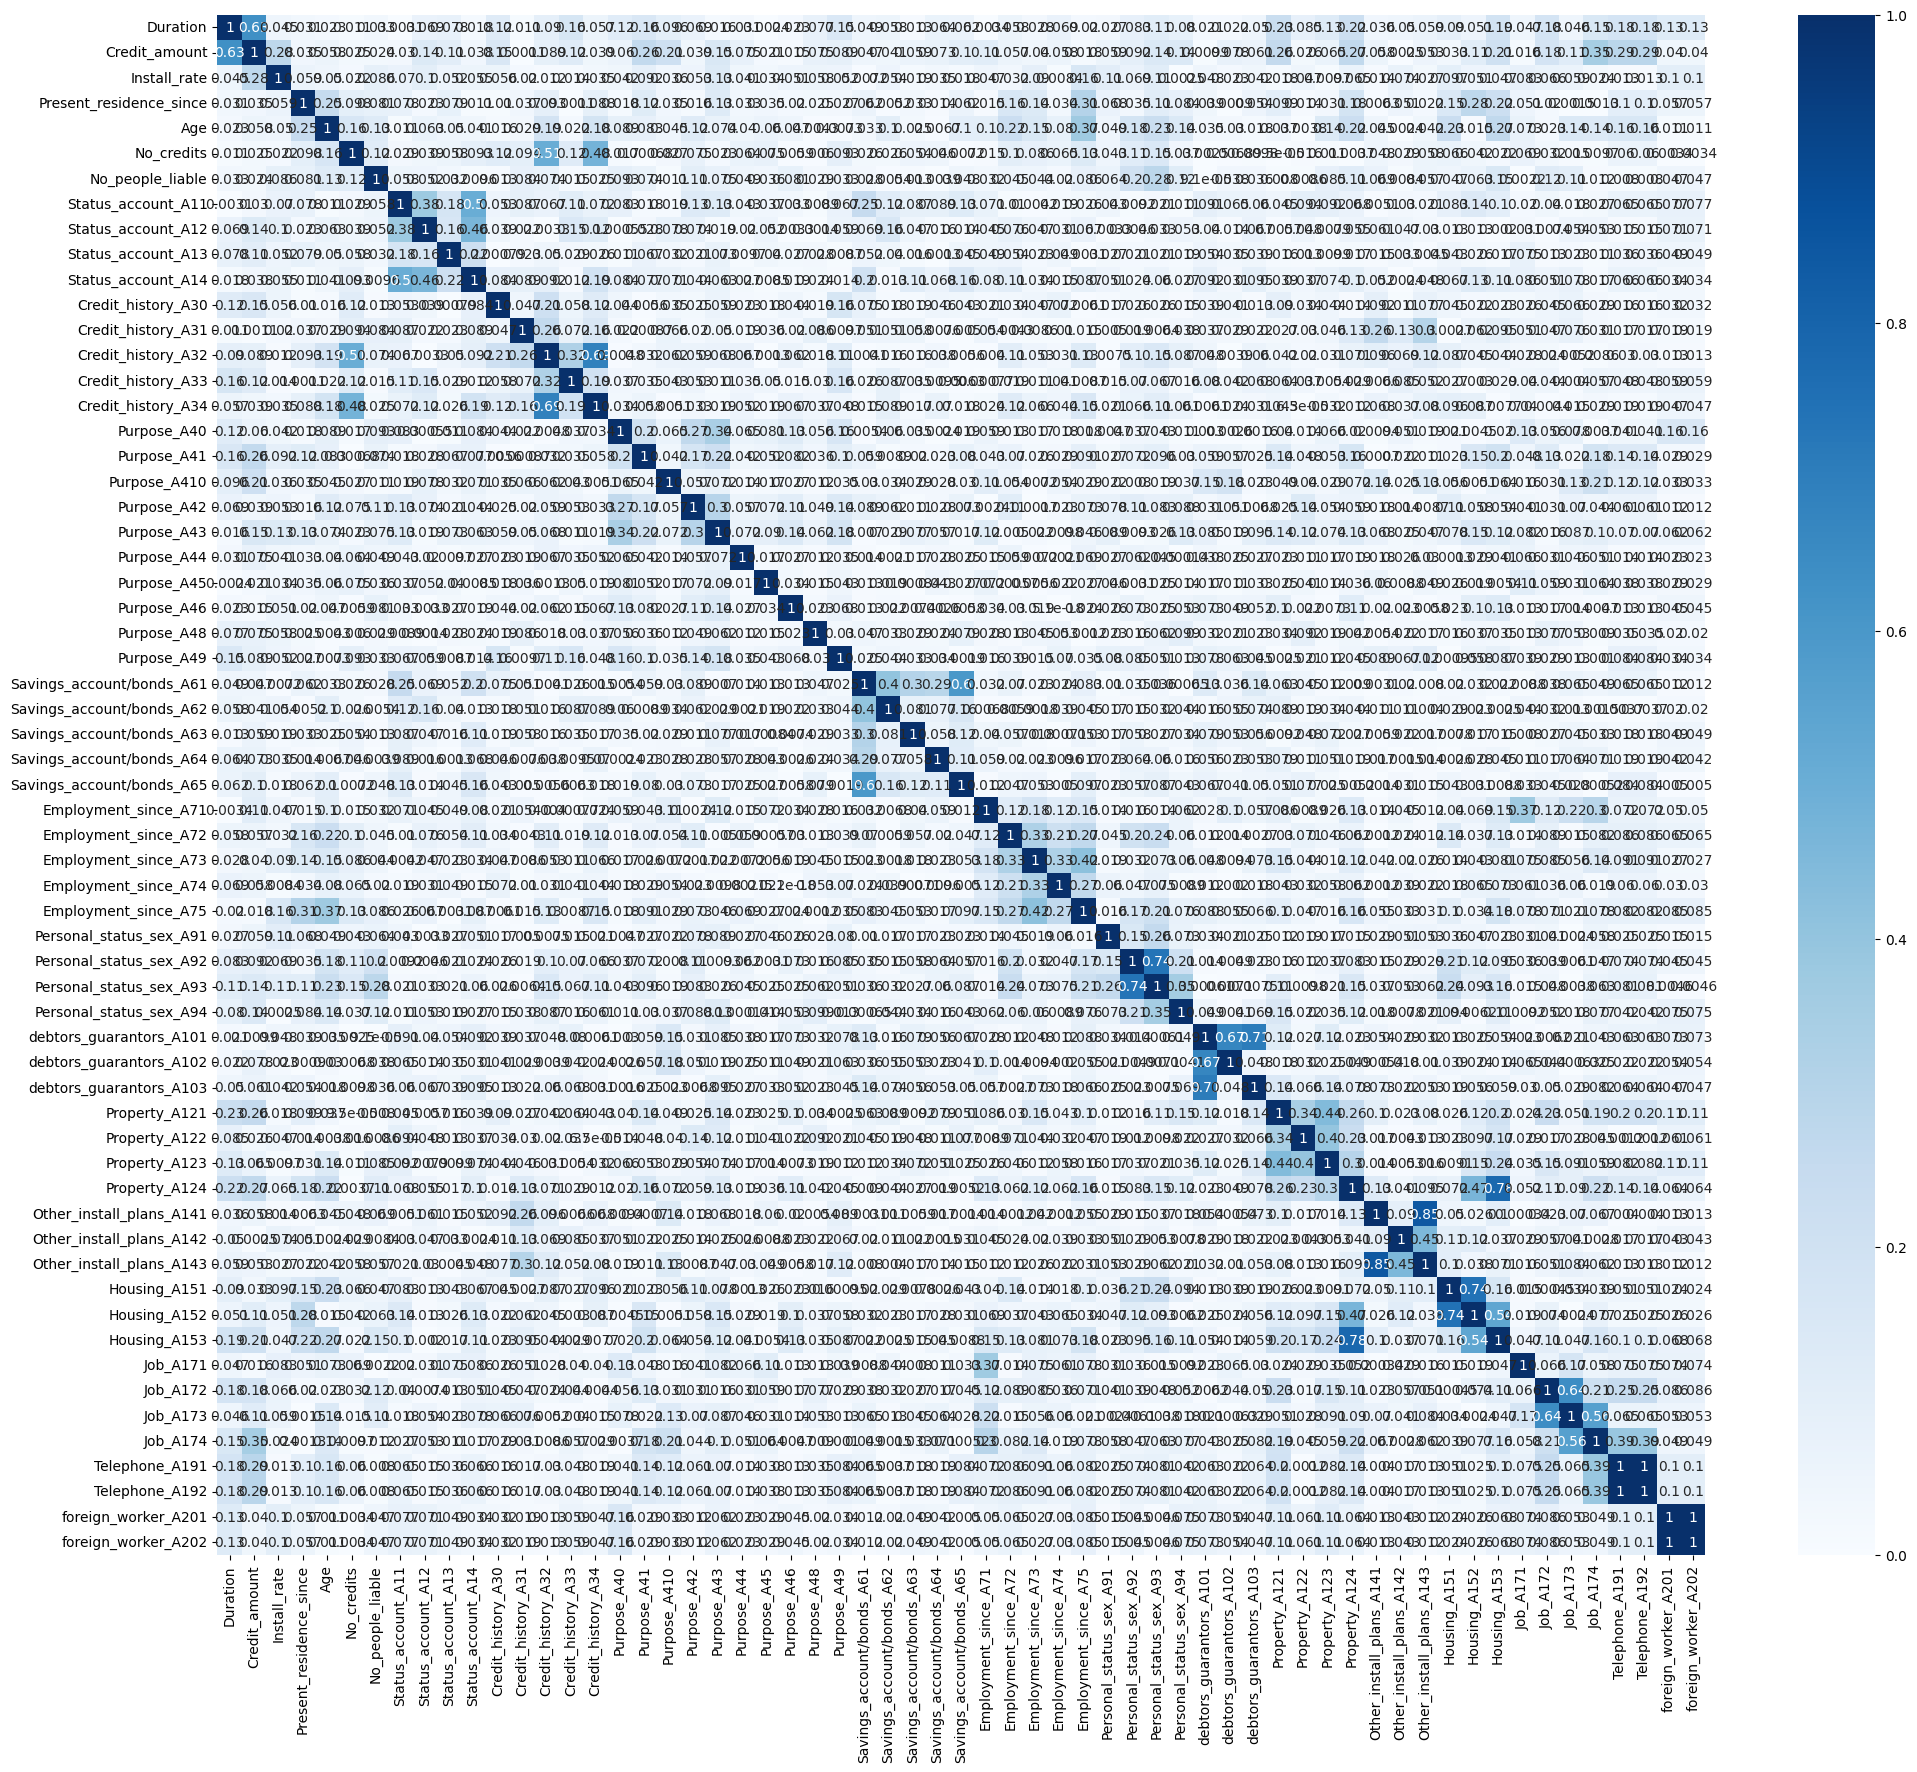

In [214]:
#### Apply dimensionality reduction techniques: t-Distributed Stochastic Neighbor Embedding (t-SNE)
#### and Principal Component Analysis (PCA) to reduce and visualize the data.

#### I compute the correlation between the features to see if there are any correlated features
correlation_analysis = X.corr().abs()

plt.figure(figsize = (24,20))
sns.heatmap(correlation_analysis, cmap="Blues", annot=True)
plt.show

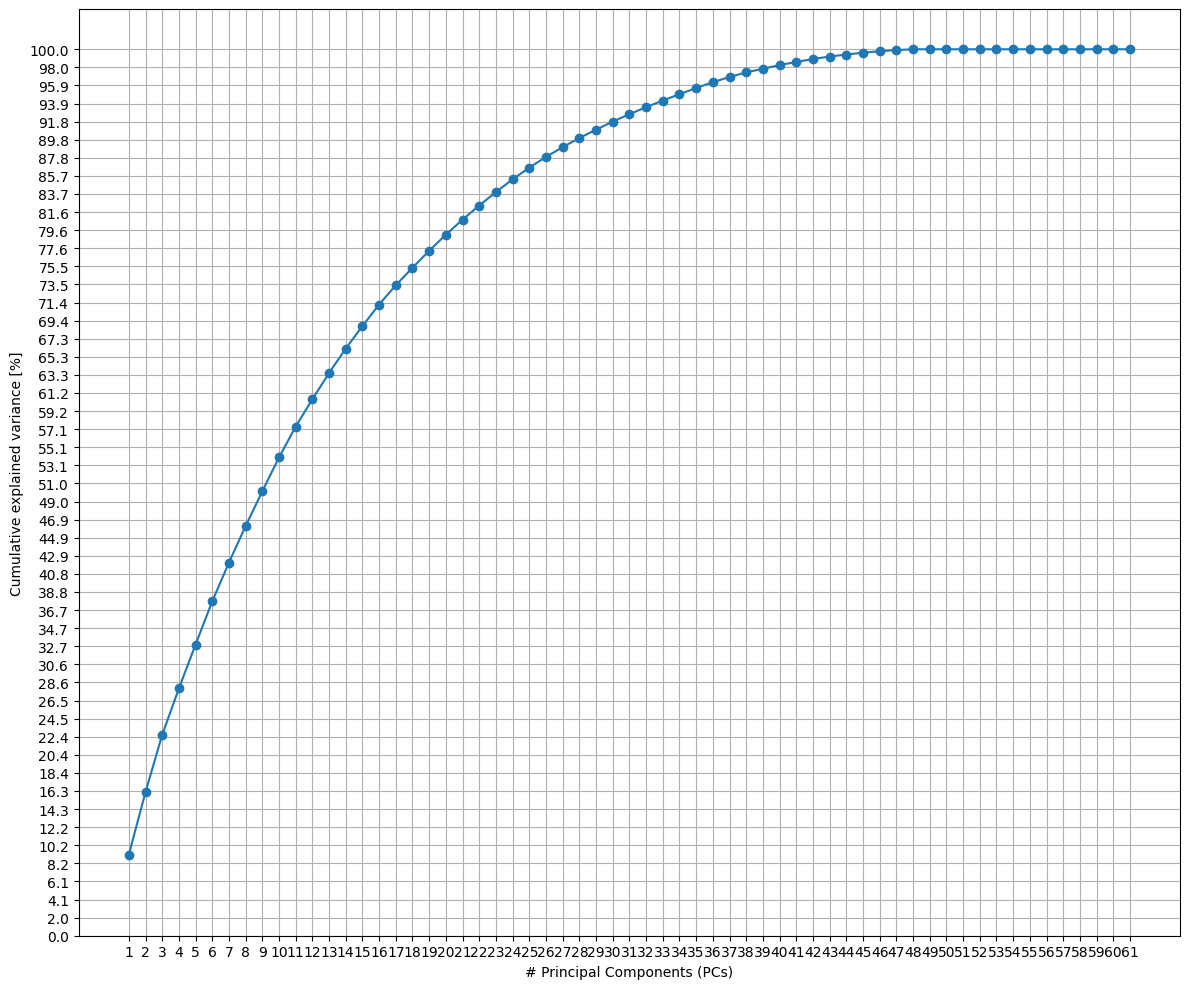

0 : 9.152967808004332
1 : 16.208713217323123
2 : 22.66197773422501
3 : 27.89231330751367
4 : 32.852208923242834
5 : 37.71869568312487
6 : 42.09680948920681
7 : 46.22164517918898
8 : 50.13932842136608
9 : 53.947714688800154
10 : 57.442312855325525
11 : 60.5185247062558
12 : 63.47825136446764
13 : 66.23488249568496
14 : 68.77713902397936
15 : 71.20402981871507
16 : 73.38331486266651
17 : 75.35208973135624
18 : 77.26835824047164
19 : 79.08379697782551
20 : 80.78435662395216
21 : 82.37520953935288
22 : 83.88769471587815
23 : 85.32898286721495
24 : 86.64474684460215
25 : 87.85674868785401
26 : 88.95082155986596
27 : 89.98438215007283
28 : 90.92654915636852
29 : 91.83844761082337
30 : 92.67661814827393
31 : 93.46866554764507
32 : 94.21561350907521
33 : 94.93135423048433
34 : 95.62937171497326
35 : 96.28548506874
36 : 96.87016770039298
37 : 97.39012232536622
38 : 97.80700111757767
39 : 98.21713351146728
40 : 98.56838537879543
41 : 98.89788618927788
42 : 99.18156657153375
43 : 99.4060145158741

In [215]:
#### PCA to check the variances

pca = PCA(random_state=15)
pca.fit(X)

#### Here i compute the variability of the dataset, while the varaible number keeps increasing, 
#### until reaching all the number
explained_variance = pca.explained_variance_ratio_

#### This allows to represent the sum for each step (remember 61 features)
cum_exp_var = np.cumsum(explained_variance)

#### Representing it in percentage
perc_cum_exp_var = cum_exp_var * 100

#### Make the plot of cumulative explained variance w.r.t. number of components
plt.figure(figsize=(12, 10))
plt.plot(perc_cum_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks([i for i in range(61)], [i for i in range(1,62)])
plt.yticks(np.linspace(0,100, 50))
plt.grid()
plt.tight_layout()
plt.show()

for i in range (len(perc_cum_exp_var)):
    print(i, ":", perc_cum_exp_var[i])



In [216]:
#### I Apply t-SNE for dimensionality reduction
perplexities = [5, 10, 20, 30, 50]
learning_rate = np.linspace(10, 1000, 5)

plt.figure(figsize=(15, 10))

for i, perplexity in enumerate(perplexities, 1):
    for lr in learning_rate:
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, learning_rate = lr)
        X_tsne = tsne.fit_transform(df_normalized_no_label[columns_no_label])
        if (perplexity == 5 and lr == 10):
            transformed_df_t_sne = pd.DataFrame(X_tsne, columns = ['C1', 'C2'])

        # scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
        # plt.title(f't-SNE Visualization (Perplexity={perplexity}, Learning Rate={lr})')
        # plt.show()

transformed_df_t_sne

,C1,C2
0,9.387000,45.106659
1,-21.120193,-25.617643
2,-48.730602,24.894571
3,-40.195545,8.426905
4,43.167259,44.267723
...,...,...
995,-20.166744,-7.803782
996,47.526978,4.838389
997,-8.807094,29.463387
998,35.353855,29.948048


<Figure size 1500x1000 with 0 Axes>

In [217]:
#### I choose 47 components because I'll be able to describe 100% of the dataset
pca = PCA(n_components = 47)
pca.fit(X)

X_PCA = pca.transform(X)
X_test_PCA = pca.transform(X_test)

<function matplotlib.pyplot.show(close=None, block=None)>

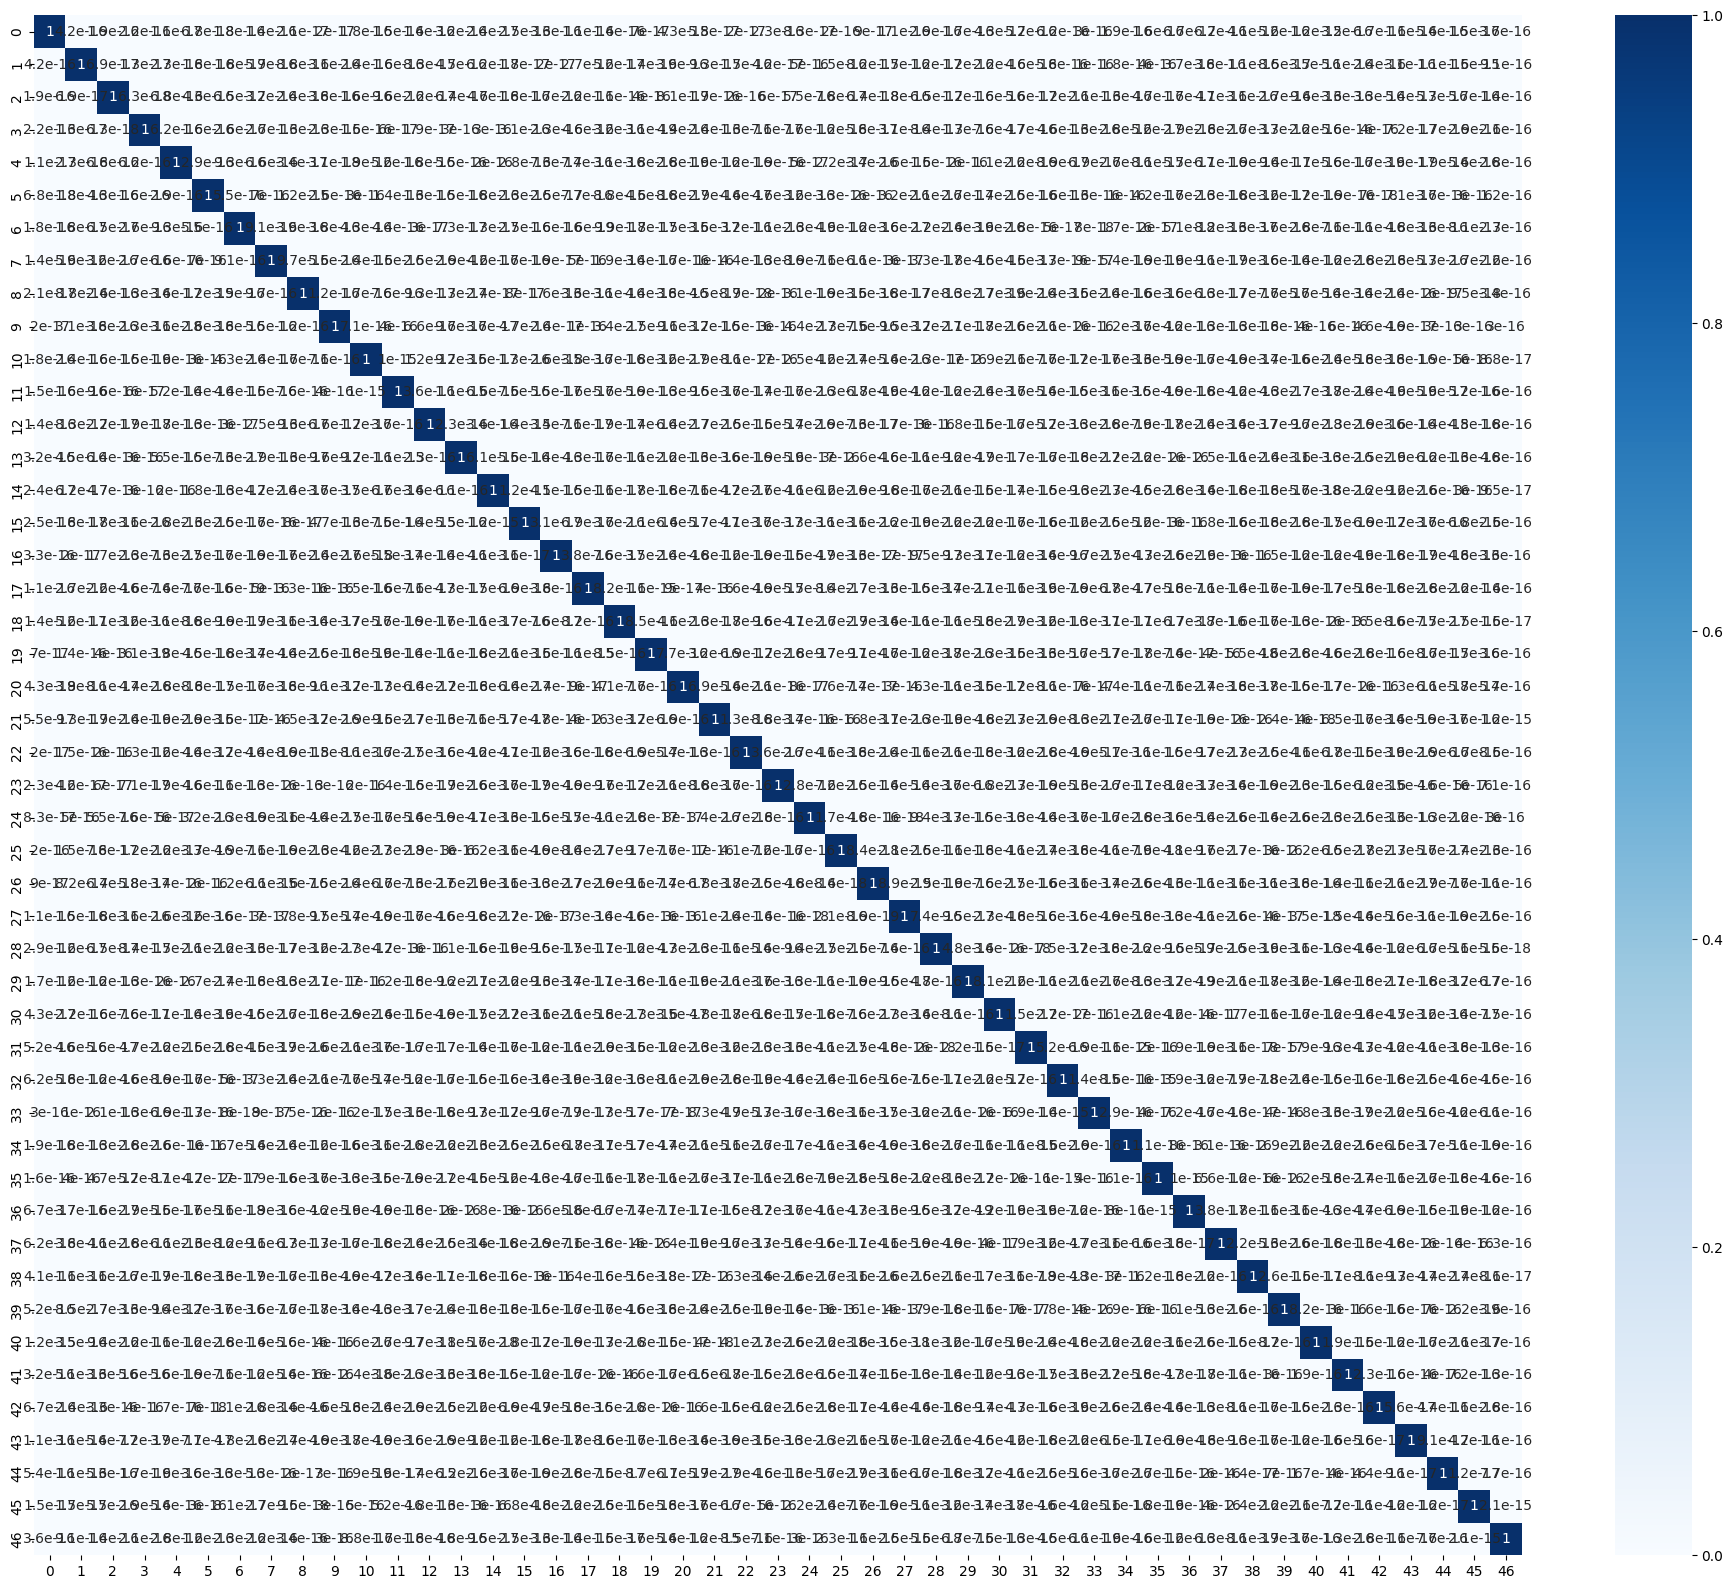

In [218]:
####Compute the correlation matrix after PCA
correlation_analysis = pd.DataFrame(X_PCA).corr().abs()
plt.figure(figsize = (24,20))
sns.heatmap(correlation_analysis, cmap="Blues", annot=True)
plt.show

#### No more correlation between different features after PCA
#### X is the transformed training dataset using PCA, it will have 45 features, 
#### with a total variance of the dataset of 99,78%

#     3 Supervised Data Analysis

### 3.1 Classifier Selection
We choose from various classifiers, notably:
- Decision Tree classifier
- Gaussian Naive Bayes classifier
- K-Nearest Neighbors classifier
- Support Vector Machines classifier
- Logistic regressor
- Neural Networks 

### 3.2 Cross-Validation

#### Here we consider non NN classifiers

In [224]:
best = 0
DT_parameters = {"criterion":['gini', 'entropy', 'log_loss'], 'max_depth':[None, 4, 6, 8, 10, 12, 14], 'min_samples_split':[2, 3, 4, 5, 6, 7, 8]}
GNB_parameters = {"var_smoothing": (np.logspace(-9,0,10))}
KNN_parameters = {"n_neighbors": range(1,31), "weights": ['uniform','distance'], "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']}
SVM_parameters = {"kernel": ['linear', 'poly', 'rbf', 'sigmoid'], "C": [100, 10, 1.0, 0.1, 0.001]}
LR_parameters = {"penalty": ['l1', 'l2', 'elasticnet', None], "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], "C": [100, 10, 1.0, 0.1, 0.01], "max_iter": [200]}
classifiers = [{"classifier": DecisionTreeClassifier, "parameters": DT_parameters}, {"classifier": GaussianNB, "parameters": GNB_parameters},
               {"classifier": KNeighborsClassifier, "parameters": KNN_parameters}, {"classifier": svm.SVC, "parameters": SVM_parameters}, 
               {"classifier": LogisticRegression, "parameters": LR_parameters}]

for classifier in classifiers:
    clf = GridSearchCV(classifier["classifier"](), classifier["parameters"], cv = 20, scoring = 'accuracy', n_jobs=10)
    clf.fit(X, y)
    if (clf.best_score_ > best):
        best = clf.best_score_
        best_clf = clf
        best_clf_name = classifier["classifier"]
        best_clf_score = clf.best_score_
    print("Best Score for " + str(classifier["classifier"]()).replace("()","") + ":", clf.best_score_,"\n")

print("\nBest Classifier: " + str(best_clf_name()).replace("()",""))
print("Best Score: ",best_clf_score)

Best Score for DecisionTreeClassifier: 0.7099999999999999 

Best Score for GaussianNB: 0.7450000000000001 

Best Score for KNeighborsClassifier: 0.74375 

Best Score for SVC: 0.76375 



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best Score for LogisticRegression: 0.7687499999999999 


Best Classifier: LogisticRegression
Best Score:  0.7687499999999999


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Here we first split the dataset into train and validation sets

In [220]:
#### splitting data into train and val

print(f"X is: {len(X)}")
print(f"y is: {len(y)}")

X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    stratify=y, 
    train_size=0.75, 
    random_state=10
)

print(f"X_train is: {len(X_train)}")
print(f"y_train is: {len(y_train)}")
print(f"X_val is: {len(X_val)}")
print(f"y_val is: {len(y_val)}")
print(f"X_test is: {len(X_test)}")
print(f"y_test is: {len(y_test)}")

#### transform numpy array to pytorch tensor
X_train_t = torch.tensor(X_train.values, dtype=torch.float)
y_train_t = torch.tensor(np.ravel(y_train), dtype=torch.long)
X_val_t = torch.tensor(X_val.values, dtype=torch.float)
y_val_t = torch.tensor(np.ravel(y_val), dtype=torch.long)
X_test_t = torch.tensor(X_test.values, dtype=torch.float)
y_test_t = torch.tensor(np.ravel(y_test), dtype=torch.long)

X is: 800
y is: 800
X_train is: 600
y_train is: 600
X_val is: 200
y_val is: 200
X_test is: 200
y_test is: 200


#### Definition of Neural Network model

In [221]:
#### defining the nn model
class Model_classification_multi(nn.Module): 

    def __init__(self, in_features, out_features, hidden_1, hidden_2, hidden_3, act):
        super().__init__()

        # another way to define the architecture of neural network
        self.layers = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_1),
            act,
            nn.Linear(in_features=hidden_1, out_features=hidden_2),
            act,
            nn.Linear(in_features=hidden_2, out_features=hidden_3),
            act,
            nn.Linear(in_features=hidden_2, out_features=out_features), 
        )

    #### define feedforward process
    def forward(self, x):
        out = F.sigmoid(self.layers(x))
        return out

#### define the loss function
loss_fn = nn.CrossEntropyLoss()

#### define the accuracy function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred))
    return acc

#### Grid search for Neural Network model

In [222]:
#defining the parameters for the grid search
n_possible_act = [nn.ReLU(), nn.Tanh()]
n_possible_nodes = [63,163,1063]
n_possible_lr = [ 1e-2,1e-4,1e-6 ]
epochs = 200
best_acc = 0
best_mode = {'act': None,'n_nodes': None,'lr': None}

for act in n_possible_act:
    for n_nodes in n_possible_nodes:
        for lr in n_possible_lr:
                        
            # set a random seed 
            torch.seed()

            # initialize the model with the correspoding parameters
            model = Model_classification_multi(
                in_features = X_train_t.shape[-1], 
                out_features = np.unique(y_train).shape[0], 
                hidden_1 = n_nodes, 
                hidden_2 = n_nodes,
                hidden_3 = n_nodes,
                act=act
            )

            # define the optimizer (pass the parameters (model) that you want to optimize, and the learning rate)
            optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

            print(f"\n***** Test with lr={lr}, n_nodes={n_nodes}, act={act} ****")
        
            loss_train_all = []
            loss_val_all = []
            loss_test_all = []
            acc_train_all = []
            acc_val_all = []
            acc_test_all = []
            best_avg = 0

            for epoch in range(epochs):
                
                # model training phase
                model.train()
                y_prob = model(X_train_t).squeeze() # get the output probability of predictions
                loss = loss_fn(y_prob, y_train_t) # calculate the loss
                optimizer.zero_grad() # reset the gradients of model parameters
                loss.backward() # backpropagate the prediction loss
                optimizer.step() # adjust the parameters by the gradients 

                # model evaluation phase
                model.eval()

                # training set
                y_prob = model(X_train_t).squeeze()
                y_pred = torch.argmax(y_prob, dim=-1) # get the label
                acc_train = accuracy_fn(y_true=y_train_t, y_pred=y_pred)

                # validation set
                y_prob = model(X_val_t).squeeze()
                loss_val = loss_fn(y_prob, y_val_t) 
                y_pred = torch.argmax(y_prob, dim=-1) 
                acc_val = accuracy_fn(y_true=y_val_t, y_pred=y_pred)

                # test set
                y_prob = model(X_test_t).squeeze()
                loss_test = loss_fn(y_prob, y_test_t) 
                y_pred = torch.argmax(y_prob, dim=-1) 
                acc_test = accuracy_fn(y_true=y_test_t, y_pred=y_pred)

                # collect results
                loss_train_all.append(loss.detach().numpy())
                loss_val_all.append(loss_val.item())
                loss_test_all.append(loss_test.item())
                acc_train_all.append(acc_train)
                acc_val_all.append(acc_val)
                acc_test_all.append(acc_test)
                
                if(acc_val > best_acc):
                    best_acc = acc_val
                    best_mode["act"] = act
                    best_mode["n_nodes"] = n_nodes
                    best_mode["lr"] = lr

                if (epoch%50 == 0): 
                    print(f'\nEpoch: {epoch} |\n Train Loss: {loss:.5f}, Val Loss: {loss_val:.5f}, Test Loss: {loss_test:.5f},\n Train Acc: {acc_train:.2f}, Val Acc: {acc_val:.2f}, Test Acc: {acc_test:.2f}')
                    
print(f'Best Combination of Parameters : Activation Function={best_mode["act"]}, Number of Nodes={best_mode["n_nodes"]}, Learning Rate={best_mode["lr"]}')
print(f'Best Validation Accuracy = {best_acc}')


***** Test with lr=0.01, n_nodes=63, act=ReLU() ****

Epoch: 0 |
 Train Loss: 0.69696, Val Loss: 0.68244, Test Loss: 0.68260,
 Train Acc: 0.70, Val Acc: 0.70, Test Acc: 0.70

Epoch: 50 |
 Train Loss: 0.43022, Val Loss: 0.57641, Test Loss: 0.59614,
 Train Acc: 0.89, Val Acc: 0.73, Test Acc: 0.71

Epoch: 100 |
 Train Loss: 0.40002, Val Loss: 0.55635, Test Loss: 0.61429,
 Train Acc: 0.91, Val Acc: 0.76, Test Acc: 0.69

Epoch: 150 |
 Train Loss: 0.39327, Val Loss: 0.55102, Test Loss: 0.61701,
 Train Acc: 0.92, Val Acc: 0.76, Test Acc: 0.69

***** Test with lr=0.0001, n_nodes=63, act=ReLU() ****

Epoch: 0 |
 Train Loss: 0.69659, Val Loss: 0.69645, Test Loss: 0.69677,
 Train Acc: 0.30, Val Acc: 0.30, Test Acc: 0.30

Epoch: 50 |
 Train Loss: 0.68925, Val Loss: 0.68931, Test Loss: 0.68949,
 Train Acc: 0.70, Val Acc: 0.70, Test Acc: 0.70

Epoch: 100 |
 Train Loss: 0.67539, Val Loss: 0.67588, Test Loss: 0.67561,
 Train Acc: 0.70, Val Acc: 0.70, Test Acc: 0.70

Epoch: 150 |
 Train Loss: 0.64390,

### 3.3 Classifier Evaluation

#### Non-NN Classifier

              precision    recall  f1-score   support

         0.0       0.61      0.45      0.52        60
         1.0       0.79      0.88      0.83       140

    accuracy                           0.75       200
   macro avg       0.70      0.66      0.68       200
weighted avg       0.74      0.75      0.74       200



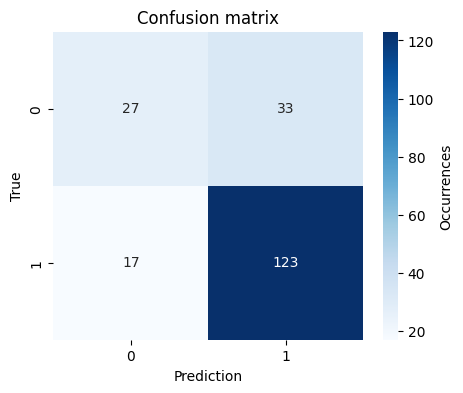

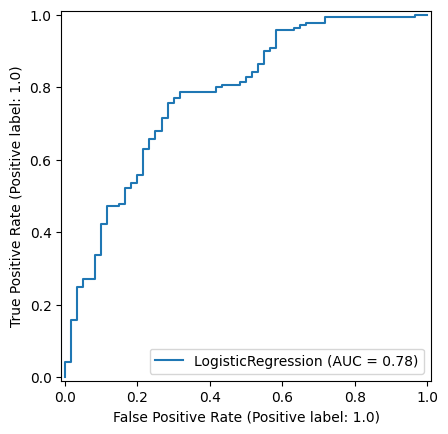

In [268]:
clf_final = best_clf_name(**best_clf.best_params_)
clf_final.fit(X, y)
y_pred = clf_final.predict(X_test)

#### Classification report
print(classification_report(y_test, y_pred))

#### Get the confusion matrix of test set
confusion = confusion_matrix(y_test, y_pred)

#### Visualize the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion, cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'}, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

#### ROC Curve
RocCurveDisplay.from_estimator(clf_final, X_test, y_test)
plt.show()

#### Neural Network

In [227]:
loss_test_all = []
acc_test_all = []
epochs = 100000
current_max_acc = 0
cnt = 0

#### set a random seed 
torch.seed()

#### initialize the model with the corresponding parameters
model = Model_classification_multi(
    in_features = X_train_t.shape[-1], 
    out_features = np.unique(y_train).shape[0], 
    hidden_1 = best_mode["n_nodes"], 
    hidden_2 = best_mode["n_nodes"],
    hidden_3 = best_mode["n_nodes"],
    act=best_mode['act']
)

optimizer = torch.optim.Adam(params=model.parameters(), lr=best_mode["lr"])
epoch = 0

while(True):

    # model training phase
    model.train()
    y_prob = model(X_train_t).squeeze() # get the output probability of predictions
    loss = loss_fn(y_prob, y_train_t) # calculate the loss
    optimizer.zero_grad() # reset the gradients of model parameters
    loss.backward() # backpropagate the prediction loss
    optimizer.step() # adjust the parameters by the gradients

    # model evaluation phase
    model.eval()

    # validation set
    y_prob = model(X_val_t).squeeze()
    loss_val = loss_fn(y_prob, y_val_t) 
    y_pred = torch.argmax(y_prob, dim=-1) 
    acc_val = accuracy_fn(y_true=y_val_t, y_pred=y_pred)

    # collect results
    loss_val_all.append(loss_val.item())
    loss_test_all.append(loss_test.item())
    acc_val_all.append(acc_val)
    acc_test_all.append(acc_test)

    if (epoch%50 == 0):
        print(f'Epoch: {epoch} | Validation Loss: {loss_val:.3f}, Validation Accuracy: {acc_val:.3f}')

    epoch += 1

    if current_max_acc -  acc_val < 0: 
        current_max_acc =  acc_val
    else:
        if (epoch > 1100):
            break

print(f'After {epoch} epochs Validation Accuracy is {acc_val:.3f}')
print(f'Best Validation Accuracy: {current_max_acc:.3f}')

Epoch: 0 | Validation Loss: 0.635, Validation Accuracy: 0.700
Epoch: 50 | Validation Loss: 0.544, Validation Accuracy: 0.770
Epoch: 100 | Validation Loss: 0.547, Validation Accuracy: 0.765
Epoch: 150 | Validation Loss: 0.548, Validation Accuracy: 0.765
Epoch: 200 | Validation Loss: 0.547, Validation Accuracy: 0.765
Epoch: 250 | Validation Loss: 0.548, Validation Accuracy: 0.765
Epoch: 300 | Validation Loss: 0.557, Validation Accuracy: 0.755
Epoch: 350 | Validation Loss: 0.572, Validation Accuracy: 0.735
Epoch: 400 | Validation Loss: 0.572, Validation Accuracy: 0.740
Epoch: 450 | Validation Loss: 0.573, Validation Accuracy: 0.740
Epoch: 500 | Validation Loss: 0.573, Validation Accuracy: 0.735
Epoch: 550 | Validation Loss: 0.574, Validation Accuracy: 0.735
Epoch: 600 | Validation Loss: 0.574, Validation Accuracy: 0.730
Epoch: 650 | Validation Loss: 0.575, Validation Accuracy: 0.730
Epoch: 700 | Validation Loss: 0.575, Validation Accuracy: 0.730
Epoch: 750 | Validation Loss: 0.576, Valida


The accuracy of validation set is: 0.720
              precision    recall  f1-score   support

           0       0.54      0.45      0.49        60
           1       0.78      0.84      0.81       140

    accuracy                           0.72       200
   macro avg       0.66      0.64      0.65       200
weighted avg       0.71      0.72      0.71       200



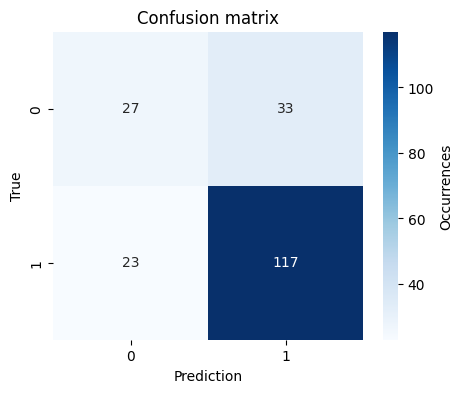

In [267]:
#### Validation set
model.eval()
y_prob = model(X_val_t).squeeze()
y_pred = torch.argmax(y_prob, dim=-1) 
acc_val = accuracy_fn(y_true=y_val_t, y_pred=y_pred)
print(f'\nThe accuracy of validation set is: {acc_val:.3f}')
print(classification_report(y_val_t, y_pred))
confusion = confusion_matrix(y_val_t, y_pred)

#### Visualize the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion, cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'}, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()


The accuracy of test set is: 0.675
              precision    recall  f1-score   support

           0       0.37      0.12      0.18        60
           1       0.71      0.91      0.80       140

    accuracy                           0.68       200
   macro avg       0.54      0.52      0.49       200
weighted avg       0.61      0.68      0.61       200



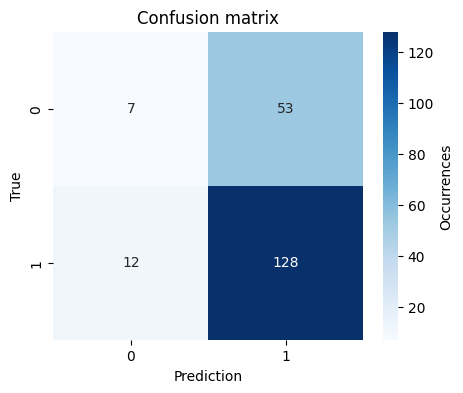

In [266]:
#### Test set
model.eval()
y_prob = model(X_test_t).squeeze()
y_pred = torch.argmax(y_prob, dim=-1) 
acc_test = accuracy_fn(y_true=y_test_t, y_pred=y_pred)
print(f'\nThe accuracy of test set is: {acc_test:.3f}')
print(classification_report(y_test_t, y_pred))
confusion = confusion_matrix(y_test_t, y_pred)

#### Visualize the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion, cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'}, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

# 4 Adversarial Attack #

### 4.1 Adding Random Noise

Results with Noise norm=0
              precision    recall  f1-score   support

           0       0.47      0.40      0.43        60
           1       0.76      0.81      0.78       140

    accuracy                           0.69       200
   macro avg       0.61      0.60      0.61       200
weighted avg       0.67      0.69      0.68       200

Results with Noise norm=10
              precision    recall  f1-score   support

           0       0.49      0.48      0.49        60
           1       0.78      0.79      0.78       140

    accuracy                           0.69       200
   macro avg       0.64      0.63      0.64       200
weighted avg       0.69      0.69      0.69       200

Results with Noise norm=20
              precision    recall  f1-score   support

           0       0.51      0.35      0.42        60
           1       0.75      0.86      0.80       140

    accuracy                           0.70       200
   macro avg       0.63      0.60      0.61     

Text(0, 0.5, 'Accuracy')

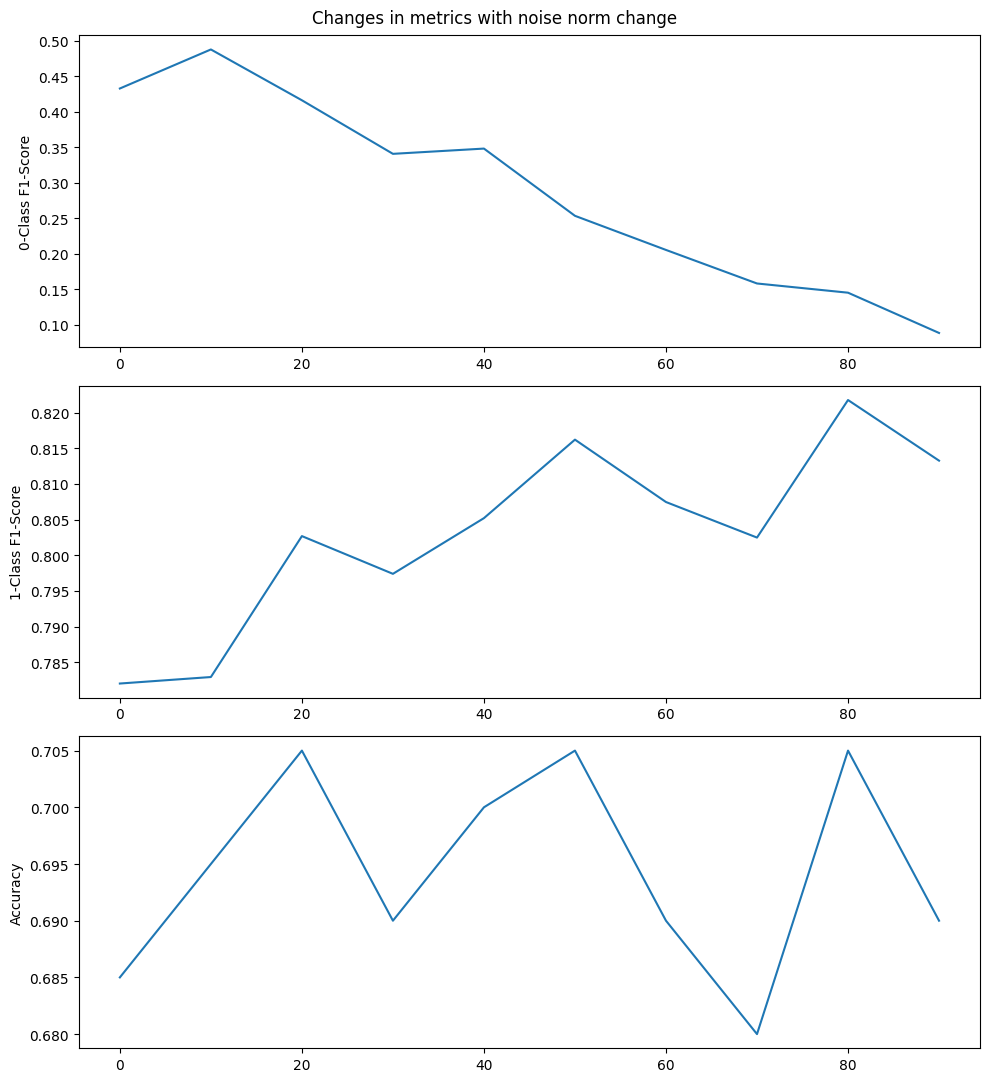

In [335]:
def add_noise_with_norm_clipping(data, norm_threshold):

    # Generate random noise with the same shape as the data
    noise = np.random.normal(size=data.shape)
    noise = pd.DataFrame(noise, index=data.index, columns=columns_no_label)

    # Calculate the Euclidean norm of the noise
    noise_norm = np.linalg.norm(noise)

    # Clip the noise to have a certain Euclidean norm
    if noise_norm > norm_threshold:
        noise = noise * (norm_threshold / noise_norm)

    # Add noise to the data
    noisy_data = data.add(noise)

    return noisy_data

accuracy = {}
# Specify the maximum Euclidean norm for the added noise
for norm_threshold in range(0,100,10):
    
    print(f'Results with Noise norm={norm_threshold}')
    # Add noise to the data with Euclidean norm clipping
    X_noisy = add_noise_with_norm_clipping(X_test[columns_no_label], norm_threshold)

    #### transform numpy array to pytorch tensor
    X_test_t = torch.tensor(X_noisy.values, dtype=torch.float)
    y_test_t = torch.tensor(np.ravel(y_test), dtype=torch.long)

    #### Test set
    model.eval()
    y_prob = model(X_test_t).squeeze()
    y_pred = torch.argmax(y_prob, dim=-1) 
    report = classification_report(y_test_t, y_pred, output_dict=True)
    print(classification_report(y_test_t, y_pred))
    accuracy[norm_threshold] = report
    confusion = confusion_matrix(y_test_t, y_pred)

    #### Visualize the confusion matrix
    #plt.figure(figsize=(5,4))
    #sns.heatmap(confusion, cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'}, fmt='d')
    #plt.xlabel('Prediction')
    #plt.ylabel('True')
    #plt.title(f'Confusion matrix for Noise norm={norm_threshold}')
    #plt.show()

fig, axs = plt.subplots(3,figsize=(10,11), tight_layout=True)
fig.suptitle('Changes in metrics with noise norm change')

values=[]
for value in accuracy.values():
    values.append(value['0']['f1-score'])
axs[0].plot(accuracy.keys(), values)
axs[0].set_ylabel('0-Class F1-Score')

values=[]
for value in accuracy.values():
    values.append(value['1']['f1-score'])
axs[1].plot(accuracy.keys(), values)
axs[1].set_ylabel('1-Class F1-Score')

values=[]
for value in accuracy.values():
    values.append(value['accuracy'])
axs[2].plot(accuracy.keys(), values)
axs[2].set_ylabel('Accuracy')


### 4.2

### 4.3 Adversarial Attack using ART

### 4.4 Countermeasures Exploration